# Semi-synthetic Spellmatch parameter sensitivity analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Algorithm convergence

In [2]:
scores_info = pd.read_csv("results/scores.csv")
source_desc = scores_info["points_file_name"].str.split("[_\.]", regex=True)
df = pd.DataFrame(
    data={
        "is_dense": source_desc.str[0] == "dense",
        "is_heterogeneous": source_desc.str[1] == "heterogeneous",
        "adj_radius": scores_info["spellmatch_adj_radius"].astype("category"),
        "converged": scores_info["error"].isna(),
    }
)

In [3]:
x = df.drop(columns="converged")
y = df["converged"]
rfc = RandomForestClassifier(bootstrap=False, random_state=123).fit(x, y)
rfc.score(x, y)

1.0

In [4]:
pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_, name="Gini importance").sort_values(ascending=False)

is_heterogeneous    0.36125
is_dense            0.35375
adj_radius          0.28500
Name: Gini importance, dtype: float64

In [5]:
df.groupby(["is_heterogeneous", "is_dense"])["converged"].mean().to_frame(name="frac_converged").reset_index()\
    .pivot(index="is_heterogeneous", columns="is_dense", values="frac_converged")

is_dense,False,True
is_heterogeneous,,
False,1.0,1.000000
True,1.0,0.333333


In [6]:
df[df["is_heterogeneous"] & df["is_dense"]].groupby("adj_radius")["converged"].sum()

adj_radius
12    0
15    1
18    0
Name: converged, dtype: int64

## Assignment strategy (pre-selection)

In [7]:
df = pd.read_csv("results/results.csv")

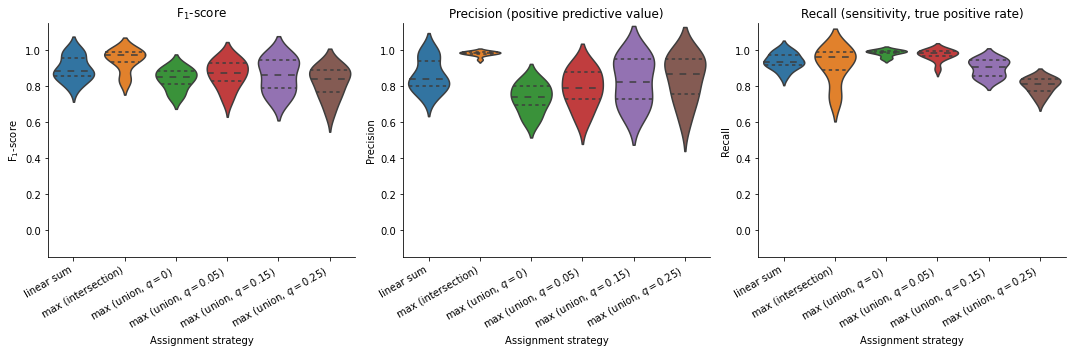

In [8]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Parameter selection

In [9]:
results_info = pd.read_csv("results/results.csv")
df = results_info[results_info["metric_name"] == "f1score"]
df = pd.DataFrame(
    data={
        "adj_radius": df["spellmatch_adj_radius"],
        "f1score": df["metric_value"],
    }
)

### Adjacency radius

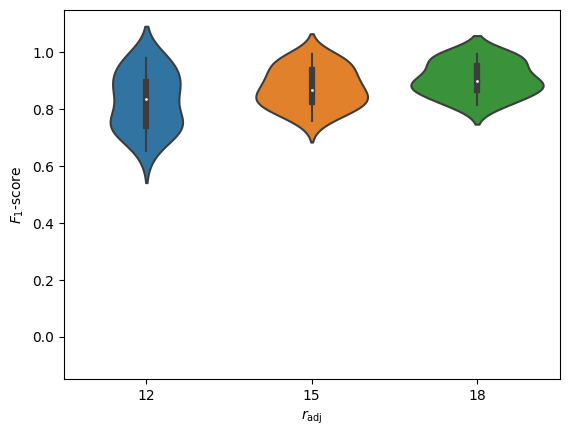

In [10]:
sns.violinplot(
    data=df,
    x="adj_radius",
    y="f1score",
)
plt.xlabel(r"$r_\mathrm{adj}$")
plt.ylabel(r"$F_1$-score")
plt.ylim(-0.15, 1.15)
plt.show()

## Assignment strategy (post-selection)

In [11]:
results_info = pd.read_csv("results/results.csv")
df = results_info[results_info["spellmatch_adj_radius"] == 18]

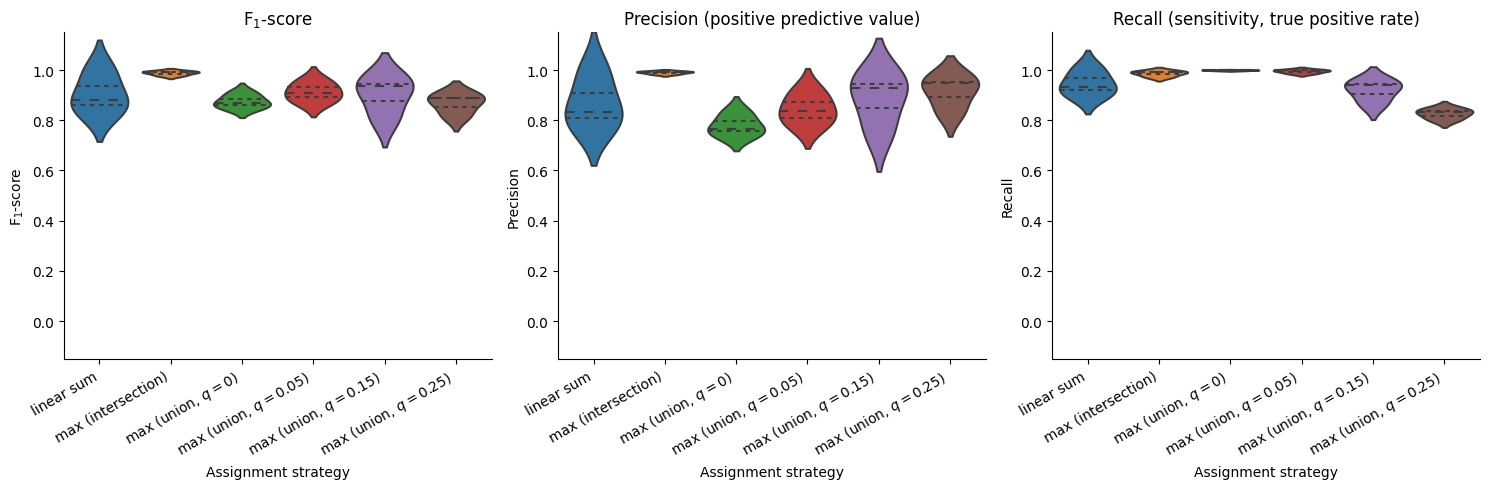

In [12]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Matching performance/uncertainty

In [13]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_adj_radius"] == 18)
    & (results_info["assignment_name"] == "max_intersect")
]

In [14]:
df.pivot(index=["points_file_name"], columns="metric_name", values="metric_value")[
    [
        "f1score", "precision", "recall",
        "uncertainty_mean", "uncertainty_std",
        "margin_mean", "margin_std",
        "entropy_mean", "entropy_std",
    ]
]

metric_name,f1score,precision,recall,uncertainty_mean,uncertainty_std,margin_mean,margin_std,entropy_mean,entropy_std
points_file_name,,,,,,,,,
dense_homogeneous.csv,0.992388,0.993387,0.991392,0.260322,0.072074,0.098143,0.049034,9.035331,1.663455
sparse_heterogeneous.csv,0.978667,0.983914,0.973475,0.654122,0.177004,0.075996,0.078010,2.870507,2.135240
sparse_homogeneous.csv,0.993243,0.993243,0.993243,0.705740,0.247635,0.179893,0.117357,0.479233,0.381030
